### Construct simulation network

In [1]:
### import packages 
from brian2 import *
from brian2.units import *
from brian2 import ms
from brian2tools import *
import matplotlib.pyplot as plts
import random
import numpy as np
import json

from simulation_runner_syn_eff import run_simulation_with_inh_ext_input, plot_raster, plot_membrane_potentials

### Proto Simulator

In [5]:
### single neuron & slow-wave situation 

N_FSN = 1
N_GPe = 1
N_STN = 1
N_MSN = 1
N_SNr = 1

fsn_params_file = './params_ref/FSN_1_nor.json'
gpet1_params_file = './params_ref/GPe_T1_1.json'
gpeta_params_file = './params_ref/GPe_TA_1_nor.json'
stn_params_file = './params_ref/STN_1.json'
msnd1_params_file = './params_ref/MSN_D1_1_nor.json' 
msnd2_params_file = './params_ref/MSN_D2_1.json' 
snr_params_file = './params_ref/SNr_1_nor.json' 


neuron_configs = [
    {
        'name': 'Cortex',
        'N': N_STN,  
        'neuron_type': 'poisson',
        'target_rates': {
            'FSN': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 646*Hz + 3*Hz * randn()'
            },
            'MSND1': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 448*Hz + 3*Hz * randn()'
            },
            'MSND2': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 592*Hz + 3*Hz * randn()'
            },
            'STN': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 170*Hz + 3*Hz * randn()'
            }
        }    
    },
    {
        'name': 'FSN',
        'N': N_FSN,
        'params_file': fsn_params_file,
        'model_class': 'FSN'
    },
    {
        'name': 'GPeT1',
        'N': N_GPe,
        'params_file': gpet1_params_file,
        'model_class': 'GPeT1',
    },
    {
        'name': 'GPeTA',
        'N': N_GPe,
        'params_file': gpeta_params_file,
        'model_class': 'GPeTA',
    },
    {
        'name': 'STN',
        'N': N_STN,
        'params_file': stn_params_file,
        'model_class': 'STN',
    },
    {
        'name': 'MSND1',
        'N': N_MSN,
        'params_file': msnd1_params_file,
        'model_class': 'MSND1',
    },
    {
        'name': 'MSND2',
        'N': N_MSN,
        'params_file': msnd2_params_file,
        'model_class': 'MSND2',
    },
    {
        'name': 'SNr',
        'N': N_SNr,
        'params_file': snr_params_file,
        'model_class': 'SNr',
    }
]

In [2]:
synapse_params = {
    # Cortex - FSN
    'csfs_g0_a': 0.5 * nS,
    'csfs_ampa_tau_syn': 12 * ms,
    'csfs_ampa_E_rev': 0 * mV,
    'csfs_delay': 2.5, 

    # Cortex - D1
    'cs1_g0_a': 0.5 * nS,
    'cs1_g0_n': 0.11 * nS,
    'cs1_ampa_tau_syn': 12 * ms,
    'cs1_nmda_tau_syn': 160 * ms,
    'cs1_ampa_E_rev': 0 * mV,
    'cs1_nmda_E_rev': 0 * mV,
    'cs1_delay': 2.5,

    # Cortex - D2
    'cs2_g0_a': 0.5 * nS,
    'cs2_g0_n': 0.019 * nS,
    'cs2_ampa_tau_syn': 12 * ms,
    'cs2_nmda_tau_syn': 160 * ms,
    'cs2_ampa_E_rev': 0 * mV,
    'cs2_nmda_E_rev': 0 * mV,
    'cs2_delay': 2.5,

    # Cortex - STN (excitatory connection)
    'csn_g0_a': 0.25 * nS,
    'csn_g0_n': 0.00625 * nS,
    'csn_ampa_tau_syn': 4 * ms,
    'csn_nmda_tau_syn': 160 * ms,
    'csn_ampa_E_rev': 0 * mV,
    'csn_nmda_E_rev': 0 * mV,
    'csn_delay': 2.5,

    # FSN - FSN
    'fsfs_g0_g': 1*nS,
    'fsfs_gaba_tau_syn': 6*ms,  
    'fsfs_gaba_E_rev': -74*mV,
    'fsfs_delay': 1.7,

    # FSN - D1 
    'fsd1_g0_g': 6*nS,
    'fsd1_gaba_tau_syn': 11*ms,  
    'fsd1_gaba_E_rev': -74*mV,
    'fsd1_delay': 1.7,

    # FSN - D2 
    'fsd2_g0_g': 6*nS,
    'fsd2_gaba_tau_syn': 11*ms,  
    'fsd2_gaba_E_rev': -74*mV,
    'fsd2_delay': 1.7,

    # D1 - SNr
    'd1snr_g0_g': 2*nS,
    'd1snr_gaba_tau_syn': 5.2 * ms,
    'd1snr_gaba_E_rev': -80 * mV,
    'd1snr_delay': 7,

    # D1 - D1 
    'd1d1_g0_g': 0.15*nS,
    'd1d1_gaba_tau_syn': 8 * ms,
    'd1d1_gaba_E_rev': -74 * mV,
    'dd_delay': 1.7,

    # D1 - D2 
    'd1d2_g0_g': 0.375*nS,
    'd1d2_gaba_tau_syn': 8 * ms,
    'd1d2_gaba_E_rev': -74 * mV,
    'dd_delay': 1.7,
    
    # D2 - D2
    'd2d2_g0_g': 0.35*nS,
    'd2d2_gaba_tau_syn': 8 * ms,
    'd2d2_gaba_E_rev': -74 * mV,
    'dd_delay': 1.7,
    
    # D2 - D1 
    'd2d1_g0_g': 0.45*nS,
    'd2d1_gaba_tau_syn': 8 * ms,
    'd2d1_gaba_E_rev': -74 * mV,
    'dd_delay': 1.7,
    
    # D2 - T1 
    'd2g1_g0_g': 2*nS,
    'd2g1_gaba_tau_syn': 6 * ms,
    'd2g1_gaba_E_rev': -65 * mV,
    'd2g1_delay': 7,

    # STN - T1 (ext)
    'snt1_g0_a': 0.35 * nS,
    'snt1_ampa_tau_syn': 12 * ms,
    'snt1_ampa_E_rev': 0 * mV,
    'snt1_delay': 2,

    # STN - TA # 30% of stn-t1
    'snta_g0_a': 0.11 * nS,
    'snta_ampa_tau_syn': 4 * ms, # 다시 확인 
    'snta_ampa_E_rev': 0 * mV,
    
    # STN - SNr
    'snsnr_g0_a':0.91 * nS,
    'snsnr_ampa_tau_syn': 12 * ms,
    'snsnr_ampa_E_rev':0 * mV,
    'snsnr_delay': 4.5,

    # GPeT1 - FSN
    'g1fs_g0_g': 2*nS,
    'g1fs_gaba_tau_syn': 17 * ms,
    'g1fs_gaba_E_rev': -74 * mV,
    'g1fs_delay': 7,   

    # GPeT1 - STN
    'g1sn_g0_g': 0.08*nS,
    'g1sn_gaba_tau_syn': 8 * ms,
    'g1sn_gaba_E_rev': -84 * mV,
    'g1sn_delay': 1,
    
    # GPeT1 - SNr
    'g1snr_g0_g': 76*nS, 
    'g1snr_gaba_tau_syn': 2.1 * ms, 
    'g1snr_gaba_E_rev': -72 * mV,
    'g1snr_delay': 3,

    # T1 - T1 
    'g1g1_g0_g': 1.3*nS,
    'g1g1_gaba_tau_syn': 5 * ms,
    'g1g1_gaba_E_rev': -65 * mV,
    'g1g1_delay': 1,

    # T1 - TA 
    'g1ga_g0_g': 0.33*nS,
    'g1ga_gaba_tau_syn': 5 * ms,
    'g1ga_gaba_E_rev': -65 * mV,
    'g1ga_delay': 1,

    # TA - T1 
    'gag1_g0_g': 1.3*nS,
    'gag1_gaba_tau_syn': 5 * ms,
    'gag1_gaba_E_rev': -65 * mV,
    'gag1_delay':1,

    # TA - TA 
    'gaga_g0_g': 0.33*nS,
    'gaga_gaba_tau_syn': 5 * ms,
    'gaga_gaba_E_rev': -65 * mV,
    'gaga_delay': 1,

    # TA - FSN 
    'gafs_g0_g': 0.51*nS,
    'gafs_gaba_tau_syn': 66 * ms,
    'gafs_gaba_E_rev': -74 * mV,
    'gafs_delay': 7.0,

    # TA - D1 
    'gad1_g0_g': 0.04*nS,
    'gad1_gaba_tau_syn': 87 * ms,
    'gad1_gaba_E_rev': -74 * mV,
    'gad1_delay': 7.0,

    # TA - D2
    'gad2_g0_g': 0.08*nS,
    'gad2_gaba_tau_syn': 76 * ms,
    'gad2_gaba_E_rev': -74 * mV,
    'gad2_delay': 7.0
}

In [5]:
results = run_simulation_with_inh_ext_input(
    neuron_configs=neuron_configs,
    synapse_params=synapse_params,
    synapse_class='GPe_STN_inh_ext_dop_nor'
)

WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
INFO       No numerical integration method specified for group 'synapses_26', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_27', using method 'exact' (took 0.08s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_28', using method 'exact' (took 0.24s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_29', using method 'exact' (took 0.08s). [bria

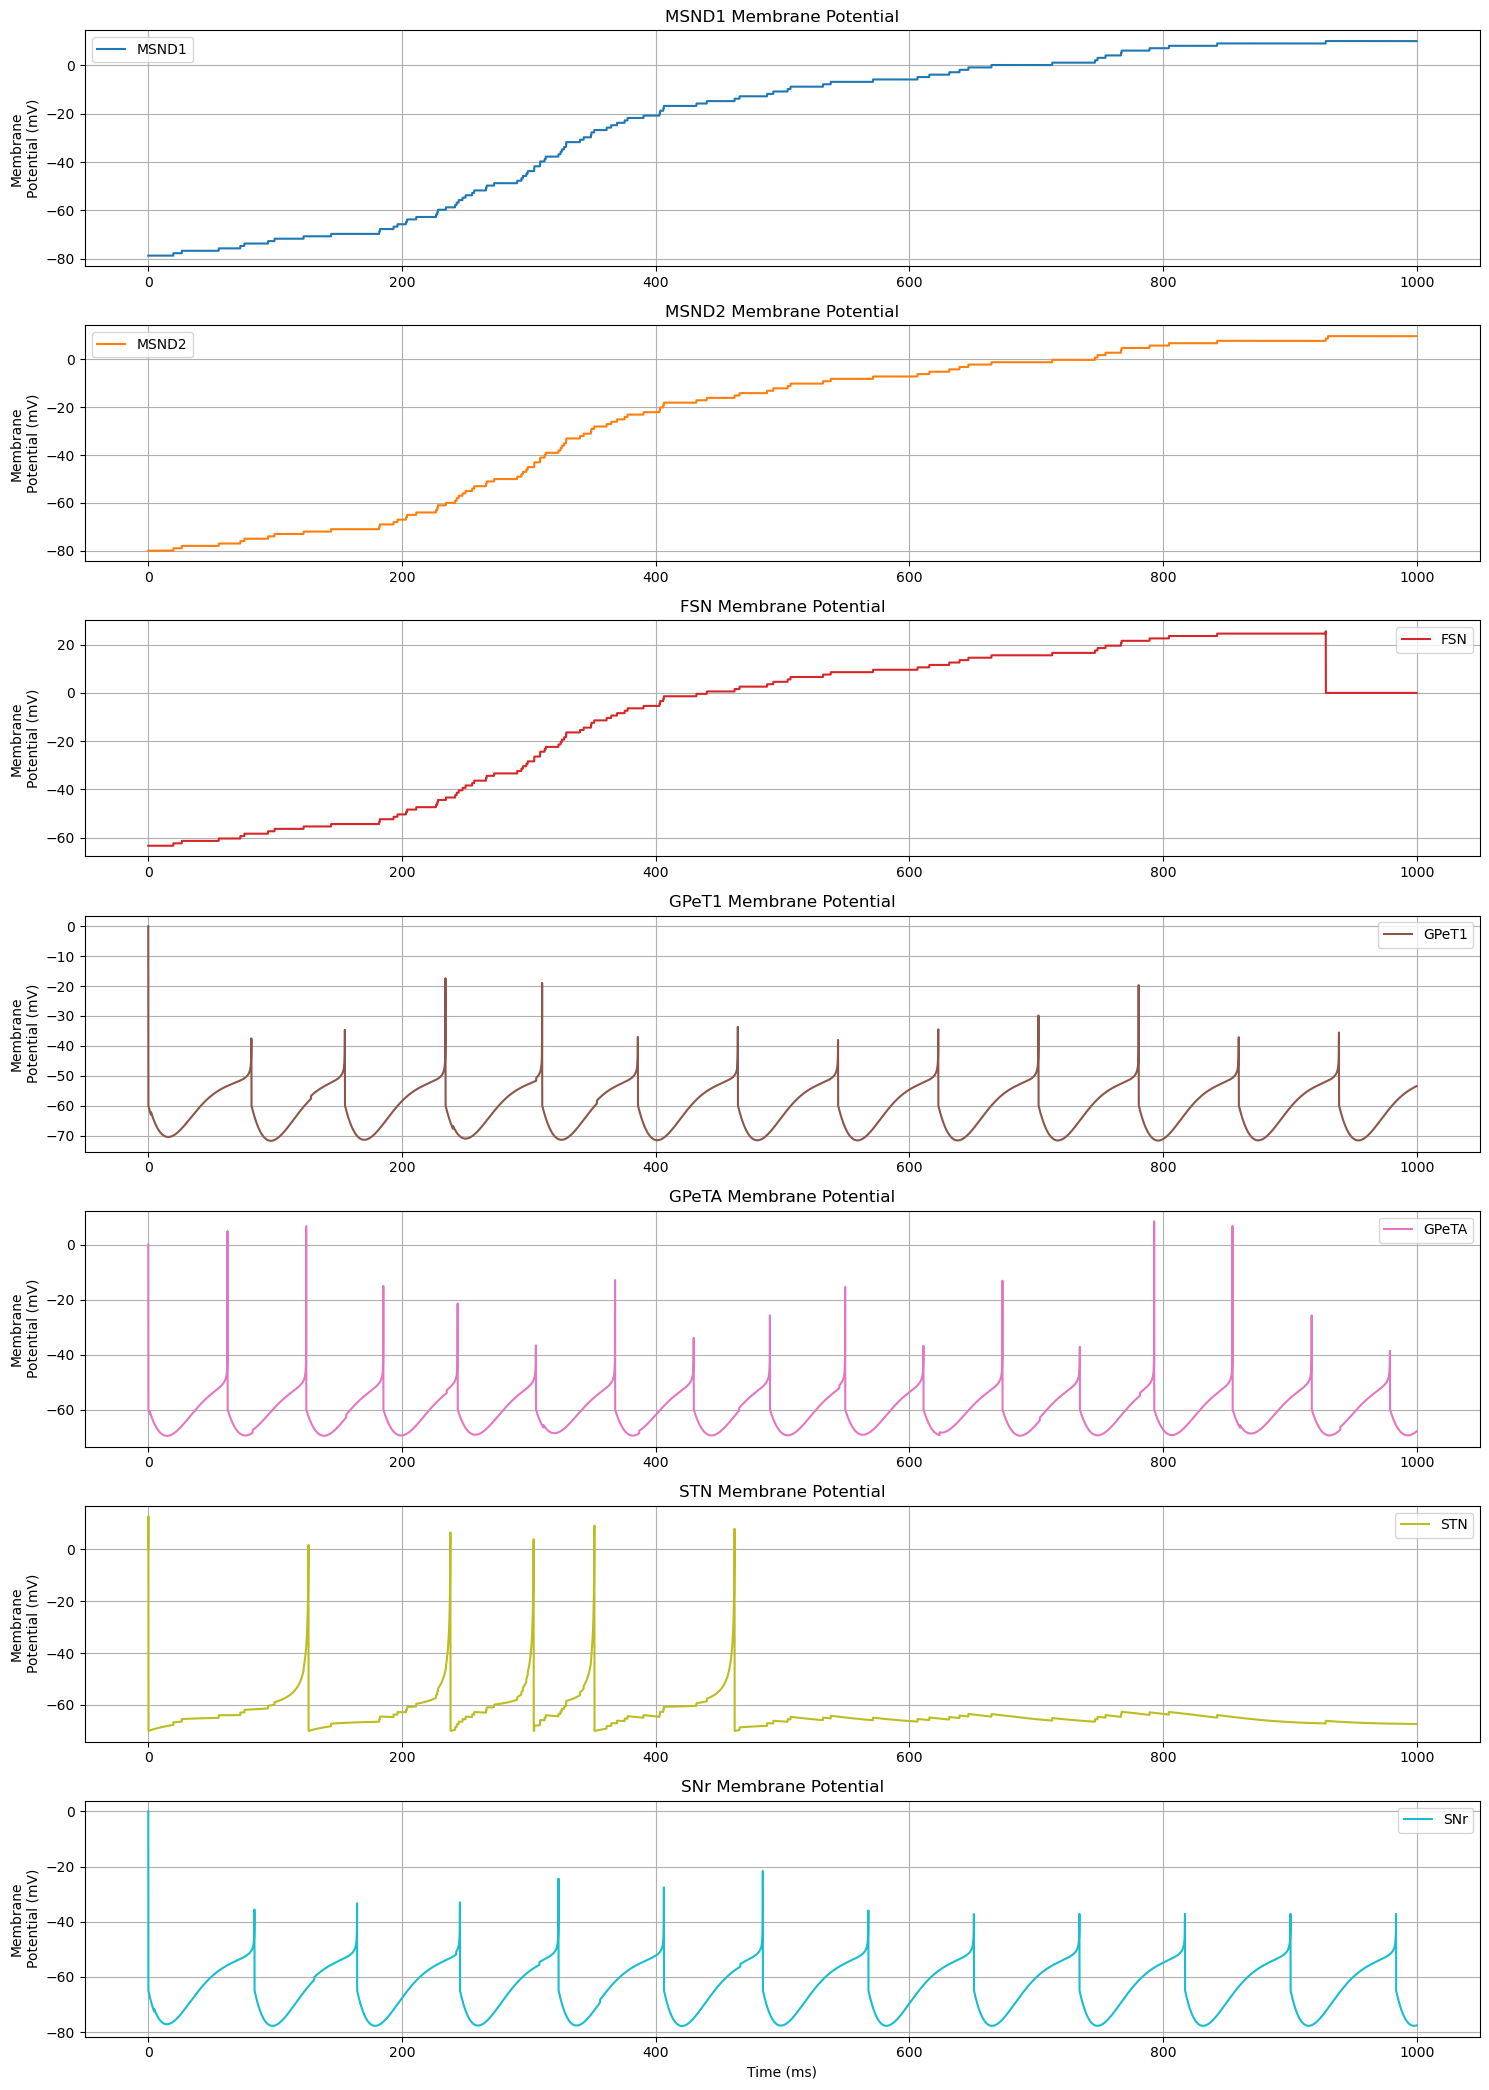

In [6]:
plot_order = ['MSND1', 'MSND2', 'FSN', 'GPeT1', 'GPeTA', 'STN', 'SNr']
plot_membrane_potentials(results, plot_order)

WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
INFO       No numerical integration method specified for group 'synapses_10', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'exact' (took 0.00s). [bria

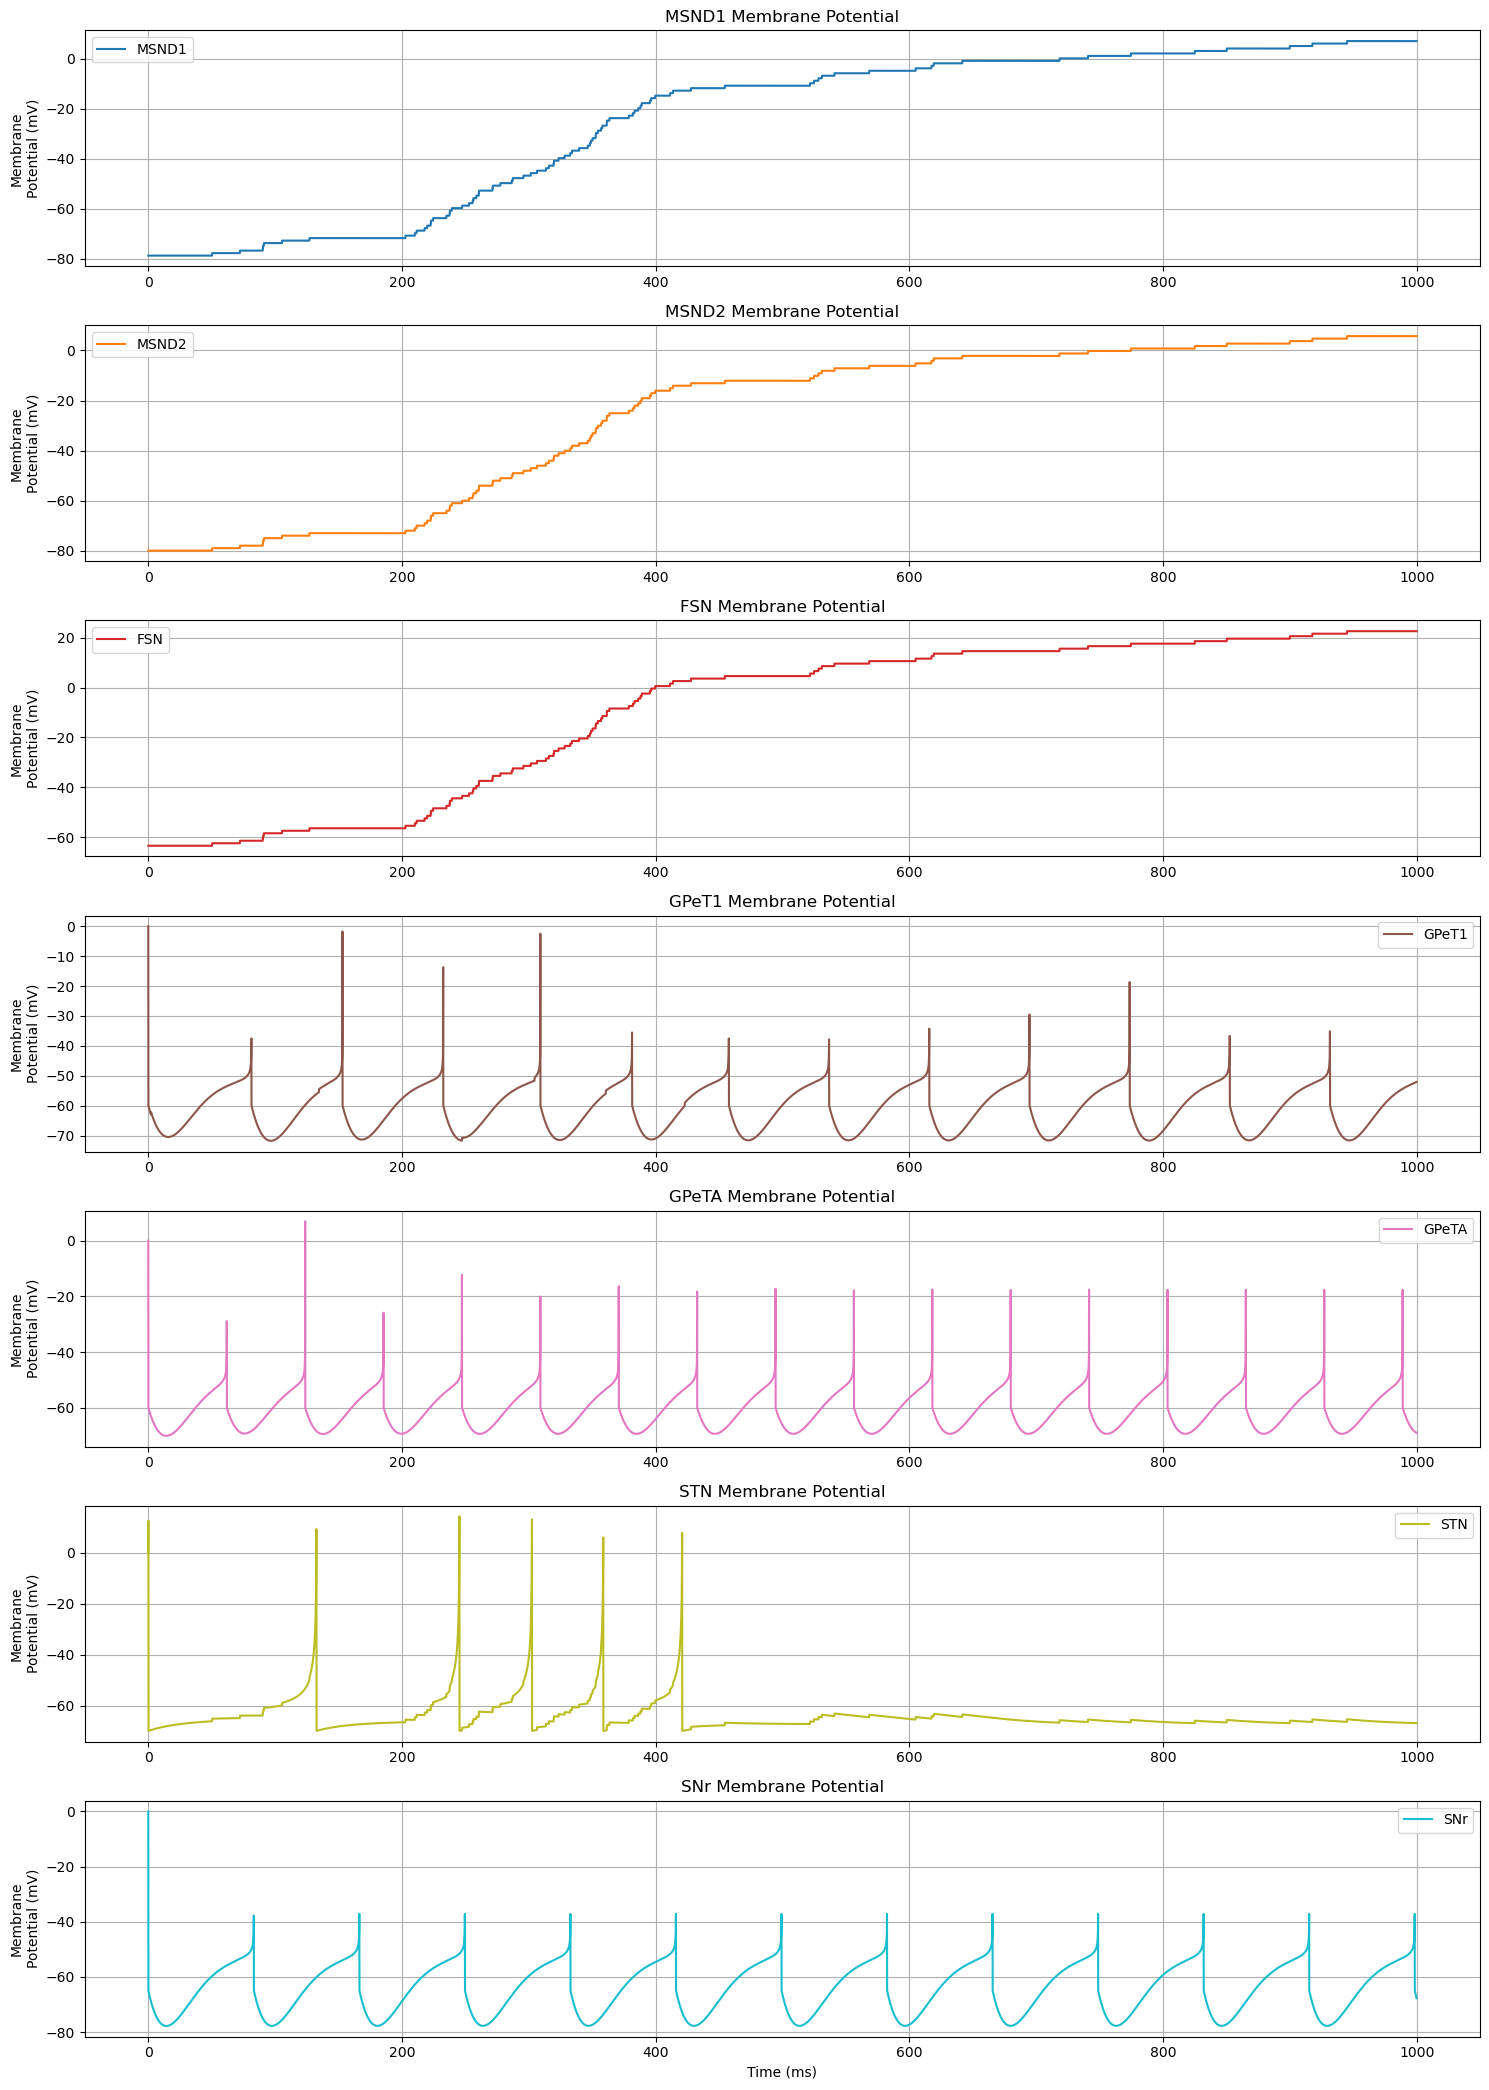

In [7]:
### single neuron & activation situation 

N_FSN = 1
N_GPe = 1
N_STN = 1
N_MSN = 1
N_SNr = 1

fsn_params_file = './params_ref/FSN_1_nor.json'
gpet1_params_file = './params_ref/GPe_T1_1.json'
gpeta_params_file = './params_ref/GPe_TA_1_nor.json'
stn_params_file = './params_ref/STN_1.json'
msnd1_params_file = './params_ref/MSN_D1_1_nor.json' 
msnd2_params_file = './params_ref/MSN_D2_1.json' 
snr_params_file = './params_ref/SNr_1_nor.json' 


neuron_configs = [
    {
        'name': 'Cortex',
        'N': N_STN,  
        'neuron_type': 'poisson',
        'target_rates': {
            'FSN': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 787*Hz + 3*Hz * randn()'
            },
            'MSND1': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 546*Hz + 3*Hz * randn()'
            },
            'MSND2': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 722*Hz + 3*Hz * randn()'
            },
            'STN': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 250*Hz + 3*Hz * randn()'
            }
        }    
    },
    {
        'name': 'FSN',
        'N': N_FSN,
        'params_file': fsn_params_file,
        'model_class': 'FSN'
    },
    {
        'name': 'GPeT1',
        'N': N_GPe,
        'params_file': gpet1_params_file,
        'model_class': 'GPeT1',
    },
    {
        'name': 'GPeTA',
        'N': N_GPe,
        'params_file': gpeta_params_file,
        'model_class': 'GPeTA',
    },
    {
        'name': 'STN',
        'N': N_STN,
        'params_file': stn_params_file,
        'model_class': 'STN',
    },
    {
        'name': 'MSND1',
        'N': N_MSN,
        'params_file': msnd1_params_file,
        'model_class': 'MSND1',
    },
    {
        'name': 'MSND2',
        'N': N_MSN,
        'params_file': msnd2_params_file,
        'model_class': 'MSND2',
    },
    {
        'name': 'SNr',
        'N': N_SNr,
        'params_file': snr_params_file,
        'model_class': 'SNr',
    }
]

results = run_simulation_with_inh_ext_input(
    neuron_configs=neuron_configs,
    synapse_params=synapse_params,
    synapse_class='GPe_STN_inh_ext_dop_nor'
)

plot_order = ['MSND1', 'MSND2', 'FSN', 'GPeT1', 'GPeTA', 'STN', 'SNr']
plot_membrane_potentials(results, plot_order)

WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
INFO       No numerical integration method specified for group 'synapses_27', using method 'exact' (took 0.08s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_28', using method 'exact' (took 0.24s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_29', using method 'exact' (took 0.08s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_30', using method 'exact' (took 0.01s). [bria

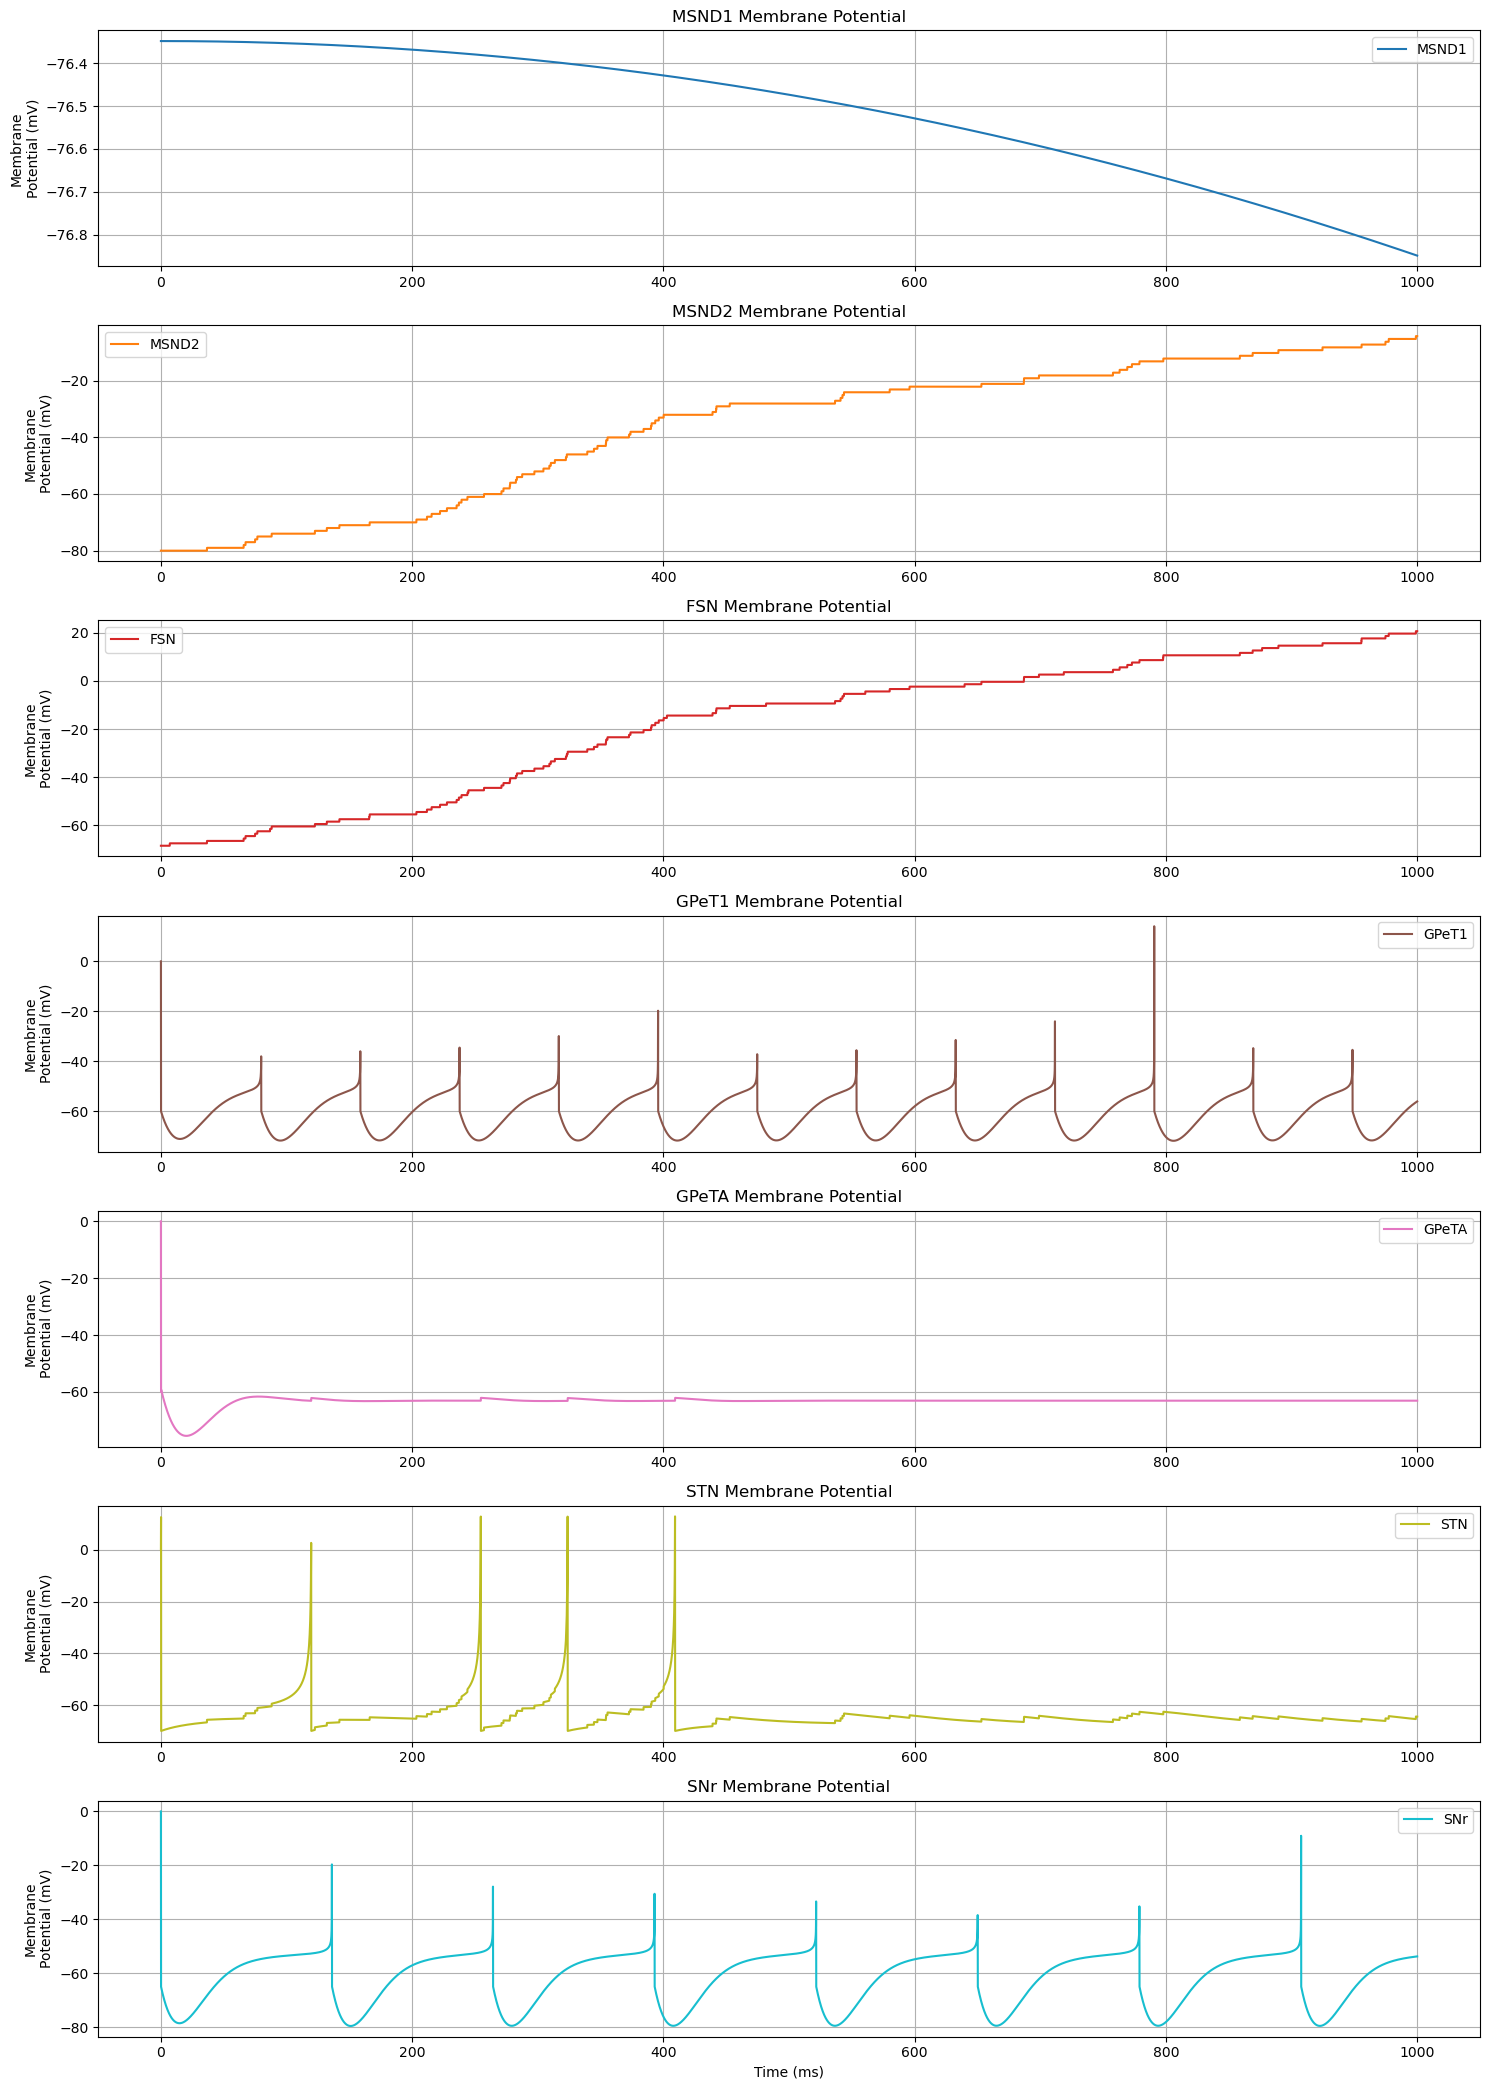

In [8]:
### single neuron & slow-wave situation (dopamine depletion)

N_FSN = 1
N_GPe = 1
N_STN = 1
N_MSN = 1
N_SNr = 1
fsn_params_file = './params_ref/FSN_1_dop.json'
gpet1_params_file = './params_ref/GPe_T1_1.json'
gpeta_params_file = './params_ref/GPe_TA_1_dop.json'
stn_params_file = './params_ref/STN_1.json'
msnd1_params_file = './params_ref/MSN_D1_1_dop.json' 
msnd2_params_file = './params_ref/MSN_D2_1.json' 
snr_params_file = './params_ref/SNr_1_dop.json' 

neuron_configs = [
    {
        'name': 'Cortex',
        'N': N_STN,  
        'neuron_type': 'poisson',
        'target_rates': {
            'FSN': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 646*Hz + 3*Hz * randn()'
            },
            'MSND1': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 448*Hz + 3*Hz * randn()'
            },
            'MSND2': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 592*Hz + 3*Hz * randn()'
            },
            'STN': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 170*Hz + 3*Hz * randn()'
            }
        }    
    },
    {
        'name': 'FSN',
        'N': N_FSN,
        'params_file': fsn_params_file,
        'model_class': 'FSN'
    },
    {
        'name': 'GPeT1',
        'N': N_GPe,
        'params_file': gpet1_params_file,
        'model_class': 'GPeT1',
    },
    {
        'name': 'GPeTA',
        'N': N_GPe,
        'params_file': gpeta_params_file,
        'model_class': 'GPeTA',
    },
    {
        'name': 'STN',
        'N': N_STN,
        'params_file': stn_params_file,
        'model_class': 'STN',
    },
    {
        'name': 'MSND1',
        'N': N_MSN,
        'params_file': msnd1_params_file,
        'model_class': 'MSND1',
    },
    {
        'name': 'MSND2',
        'N': N_MSN,
        'params_file': msnd2_params_file,
        'model_class': 'MSND2',
    },
    {
        'name': 'SNr',
        'N': N_SNr,
        'params_file': snr_params_file,
        'model_class': 'SNr',
    }
]

results = run_simulation_with_inh_ext_input(
    neuron_configs=neuron_configs,
    synapse_params=synapse_params,
    synapse_class='GPe_STN_inh_ext_dop_dep'
)

plot_order = ['MSND1', 'MSND2', 'FSN', 'GPeT1', 'GPeTA', 'STN', 'SNr']
plot_membrane_potentials(results, plot_order)

WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
INFO       No numerical integration method specified for group 'synapses_10', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'exact' (took 0.00s). [bria

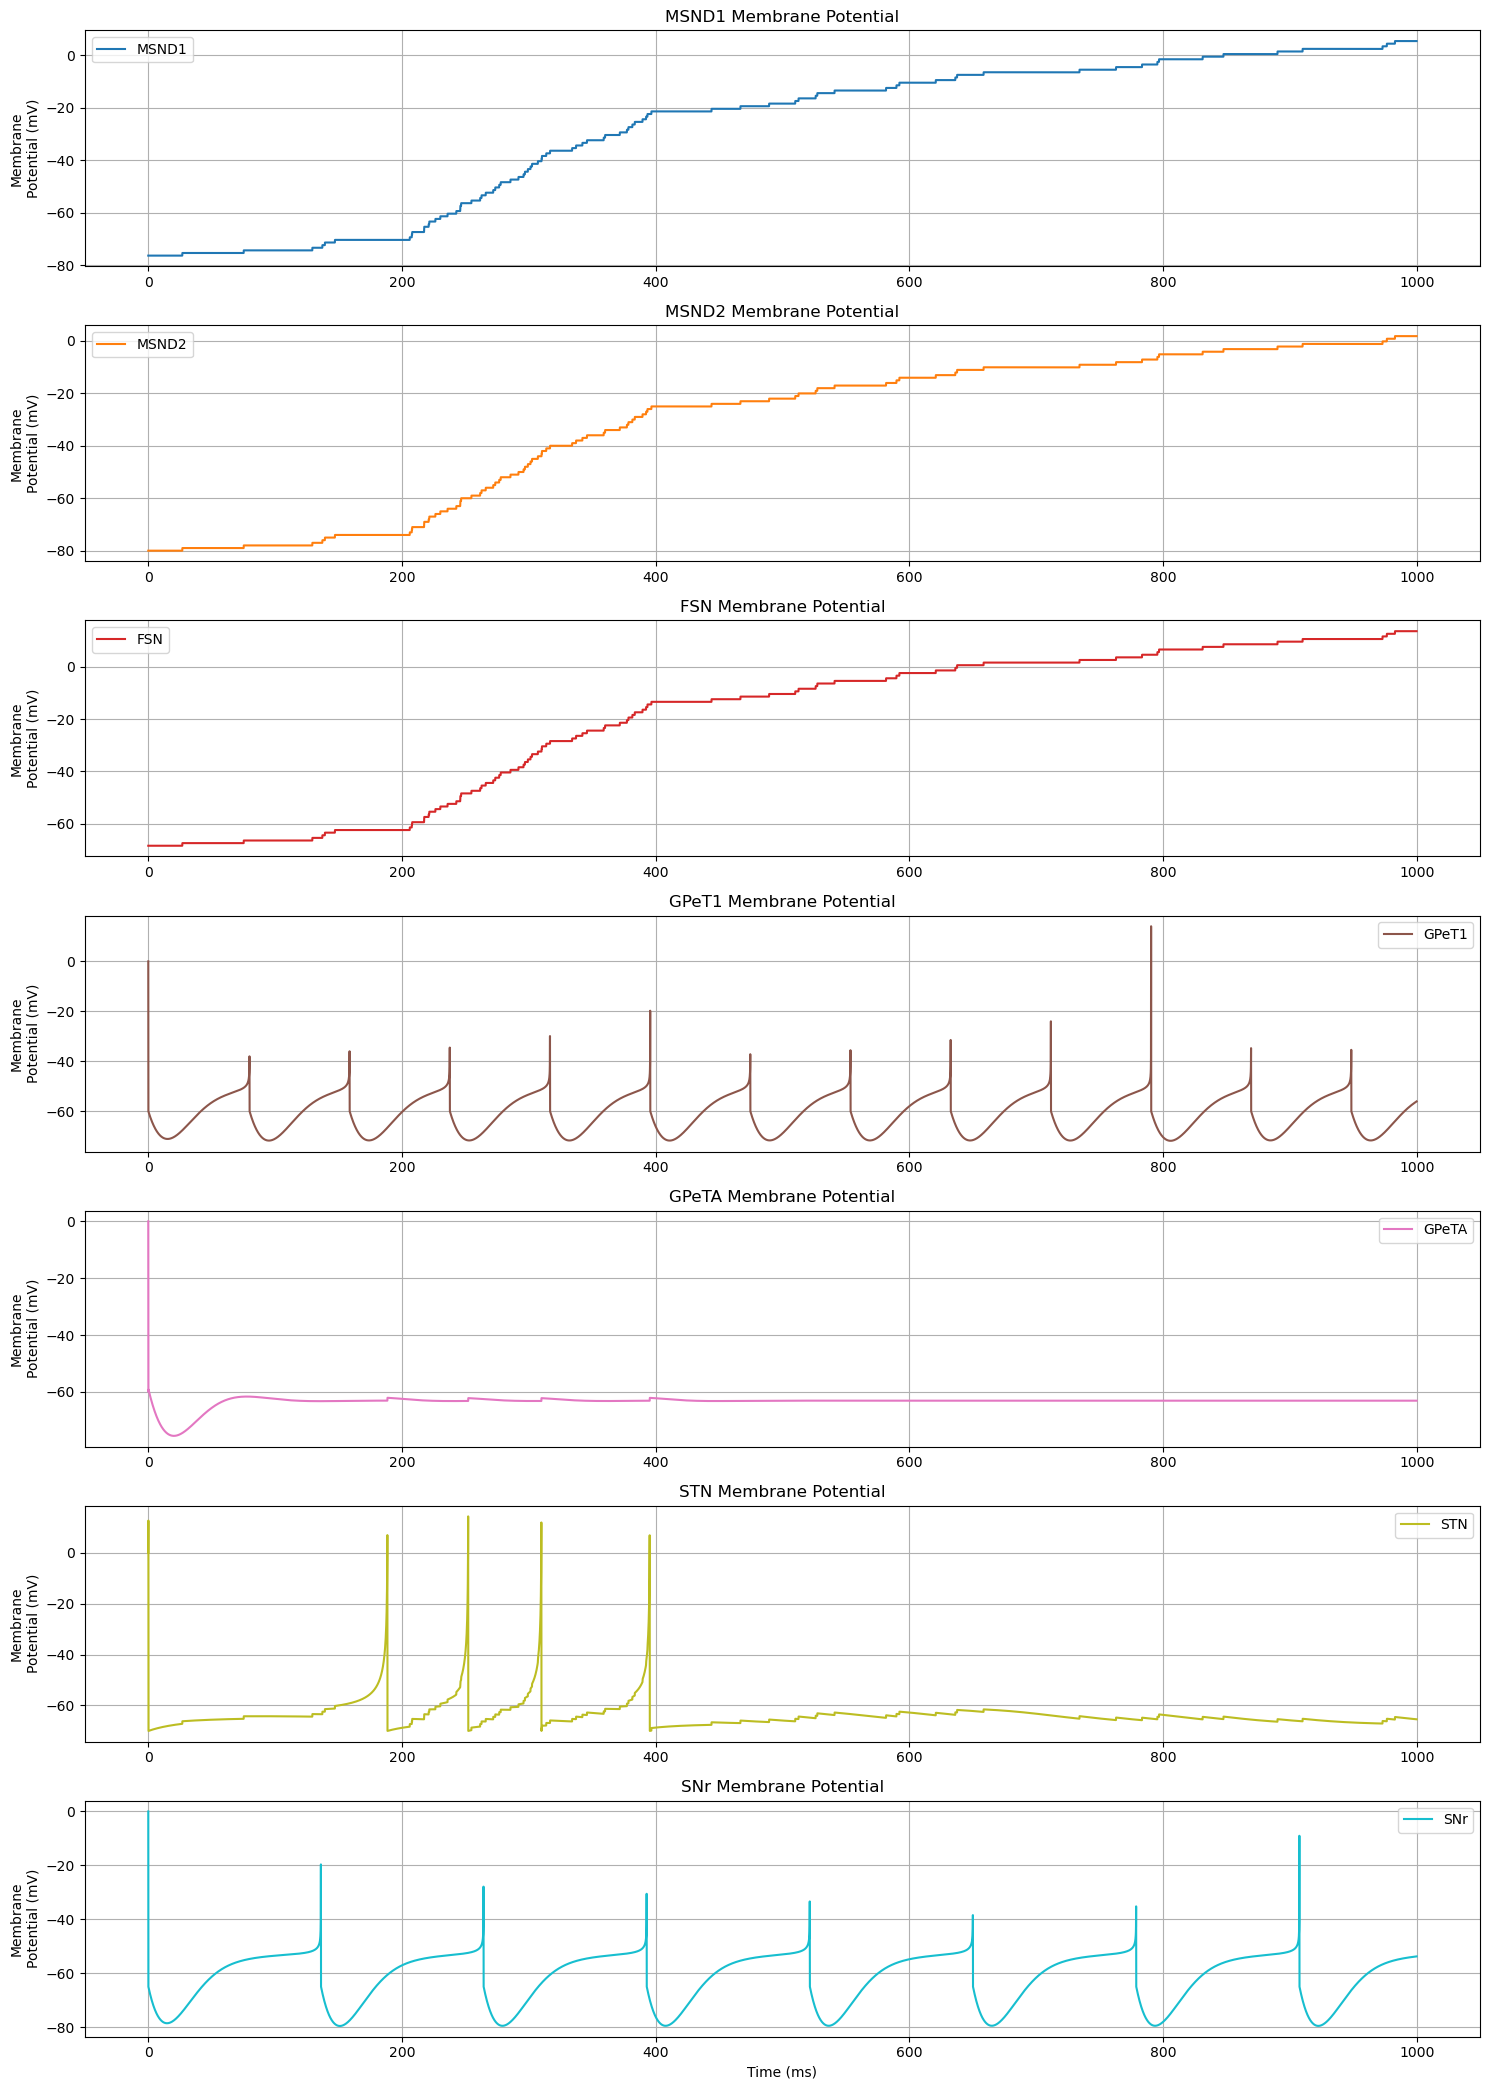

In [9]:
### single neuron & activation situation (dop depletion)

N_FSN = 1
N_GPe = 1
N_STN = 1
N_MSN = 1
N_SNr = 1
fsn_params_file = './params_ref/FSN_1_dop.json'
gpet1_params_file = './params_ref/GPe_T1_1.json'
gpeta_params_file = './params_ref/GPe_TA_1_dop.json'
stn_params_file = './params_ref/STN_1.json'
msnd1_params_file = './params_ref/MSN_D1_1_dop.json' 
msnd2_params_file = './params_ref/MSN_D2_1.json' 
snr_params_file = './params_ref/SNr_1_dop.json' 



neuron_configs = [
    {
        'name': 'Cortex',
        'N': N_STN,  
        'neuron_type': 'poisson',
        'target_rates': {
            'FSN': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 787*Hz + 3*Hz * randn()'
            },
            'MSND1': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 546*Hz + 3*Hz * randn()'
            },
            'MSND2': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 722*Hz + 3*Hz * randn()'
            },
            'STN': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 250*Hz + 3*Hz * randn()'
            }
        }    
    },
    {
        'name': 'FSN',
        'N': N_FSN,
        'params_file': fsn_params_file,
        'model_class': 'FSN'
    },
    {
        'name': 'GPeT1',
        'N': N_GPe,
        'params_file': gpet1_params_file,
        'model_class': 'GPeT1',
    },
    {
        'name': 'GPeTA',
        'N': N_GPe,
        'params_file': gpeta_params_file,
        'model_class': 'GPeTA',
    },
    {
        'name': 'STN',
        'N': N_STN,
        'params_file': stn_params_file,
        'model_class': 'STN',
    },
    {
        'name': 'MSND1',
        'N': N_MSN,
        'params_file': msnd1_params_file,
        'model_class': 'MSND1',
    },
    {
        'name': 'MSND2',
        'N': N_MSN,
        'params_file': msnd2_params_file,
        'model_class': 'MSND2',
    },
    {
        'name': 'SNr',
        'N': N_SNr,
        'params_file': snr_params_file,
        'model_class': 'SNr',
    }
]

results = run_simulation_with_inh_ext_input(
    neuron_configs=neuron_configs,
    synapse_params=synapse_params,
    synapse_class='GPe_STN_inh_ext_dop_dep'
)

plot_order = ['MSND1', 'MSND2', 'FSN', 'GPeT1', 'GPeTA', 'STN', 'SNr']
plot_membrane_potentials(results, plot_order)

### Multiple Neuron Population

WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_8zfxnm0t/var
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_8zfxnm0t/var/folders
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_8zfxnm0t/var/folders/tj
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_8zfxnm0t/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_8zfxnm0t/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc00

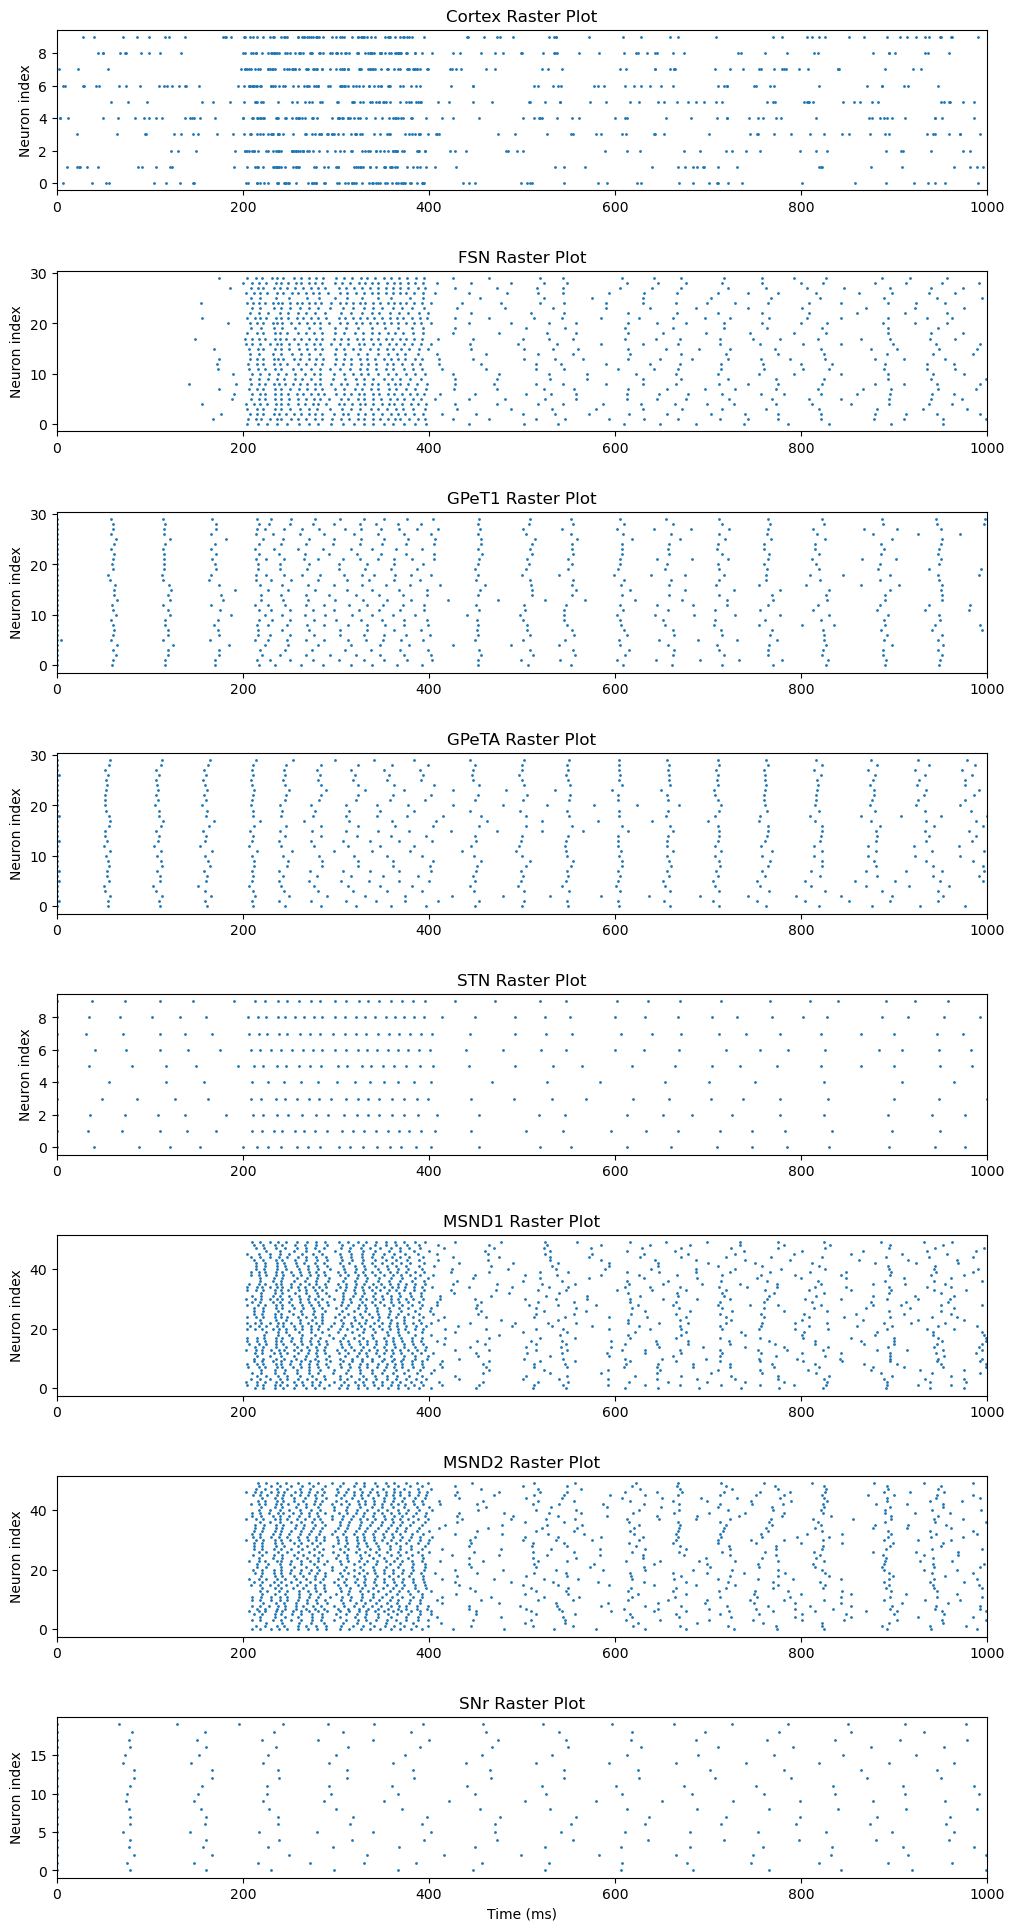

In [3]:
### slow-wave situation & normal 
fsn_params_file = './params_ref/FSN_1_nor.json'
gpet1_params_file = './params_ref/GPe_T1_1.json'
gpeta_params_file = './params_ref/GPe_TA_1_nor.json'
stn_params_file = './params_ref/STN_1.json'
msnd1_params_file = './params_ref/MSN_D1_1_nor.json' 
msnd2_params_file = './params_ref/MSN_D2_1.json' 
snr_params_file = './params_ref/SNr_1_nor.json' 

N_FSN = 30
N_GPe = 30 # 988
N_STN = 10 # 388
N_MSN = 50 # 37971
N_SNr = 20 # 754


neuron_configs = [
    {
        'name': 'Cortex',
        'N': N_STN,  
        'neuron_type': 'poisson',
        'target_rates': {
            'FSN': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 646*Hz + 3*Hz * randn()'
            },
            'MSND1': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 448*Hz + 3*Hz * randn()'
            },
            'MSND2': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 592*Hz + 3*Hz * randn()'
            },
            'STN': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 170*Hz + 3*Hz * randn()'
            }
        }    
    },
    {
        'name': 'FSN',
        'N': N_FSN,
        'params_file': fsn_params_file,
        'model_class': 'FSN'
    },
    {
        'name': 'GPeT1',
        'N': N_GPe,
        'params_file': gpet1_params_file,
        'model_class': 'GPeT1',
    },
    {
        'name': 'GPeTA',
        'N': N_GPe,
        'params_file': gpeta_params_file,
        'model_class': 'GPeTA',
    },
    {
        'name': 'STN',
        'N': N_STN,
        'params_file': stn_params_file,
        'model_class': 'STN',
    },
    {
        'name': 'MSND1',
        'N': N_MSN,
        'params_file': msnd1_params_file,
        'model_class': 'MSND1',
    },
    {
        'name': 'MSND2',
        'N': N_MSN,
        'params_file': msnd2_params_file,
        'model_class': 'MSND2',
    },
    {
        'name': 'SNr',
        'N': N_SNr,
        'params_file': snr_params_file,
        'model_class': 'SNr',
    }
]

results = run_simulation_with_inh_ext_input(
    neuron_configs=neuron_configs,
    synapse_params=synapse_params,
    synapse_class='GPe_STN_inh_ext_dop_nor'
)

plot_order = ['MSND1', 'MSND2', 'FSN', 'GPeT1', 'GPeTA', 'STN', 'SNr']
plot_raster(results)

WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]


WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
INFO       No numerical integration method specified for group 'synapses_26', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_27', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_28', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_29', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_30', using method 'exact' (to

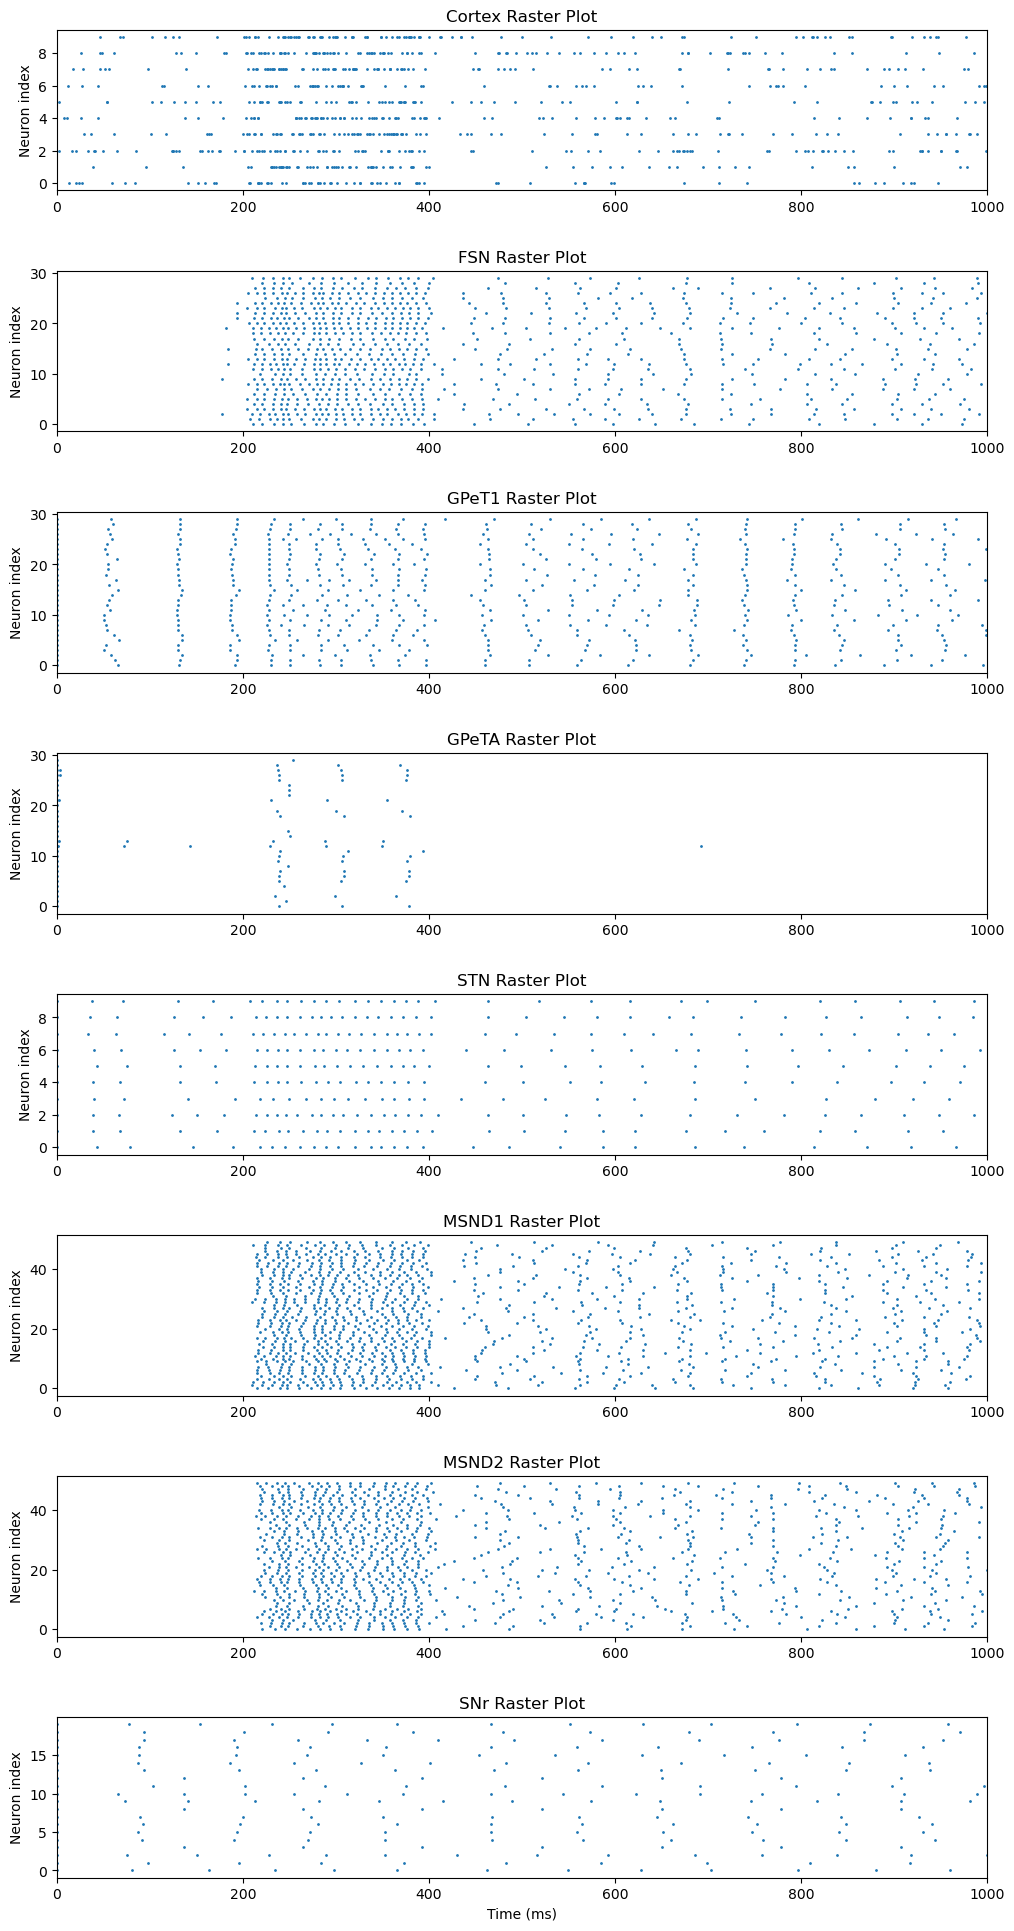

In [4]:
### slow-wave situation & dop 
fsn_params_file = './params_ref/FSN_1_dop.json'
gpet1_params_file = './params_ref/GPe_T1_1.json'
gpeta_params_file = './params_ref/GPe_TA_1_dop.json'
stn_params_file = './params_ref/STN_1.json'
msnd1_params_file = './params_ref/MSN_D1_1_dop.json' 
msnd2_params_file = './params_ref/MSN_D2_1.json' 
snr_params_file = './params_ref/SNr_1_dop.json' 

neuron_configs = [
    {
        'name': 'Cortex',
        'N': N_STN,  
        'neuron_type': 'poisson',
        'target_rates': {
            'FSN': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 646*Hz + 3*Hz * randn()'
            },
            'MSND1': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 448*Hz + 3*Hz * randn()'
            },
            'MSND2': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 592*Hz + 3*Hz * randn()'
            },
            'STN': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 170*Hz + 3*Hz * randn()'
            }
        }    
    },
    {
        'name': 'FSN',
        'N': N_FSN,
        'params_file': fsn_params_file,
        'model_class': 'FSN'
    },
    {
        'name': 'GPeT1',
        'N': N_GPe,
        'params_file': gpet1_params_file,
        'model_class': 'GPeT1',
    },
    {
        'name': 'GPeTA',
        'N': N_GPe,
        'params_file': gpeta_params_file,
        'model_class': 'GPeTA',
    },
    {
        'name': 'STN',
        'N': N_STN,
        'params_file': stn_params_file,
        'model_class': 'STN',
    },
    {
        'name': 'MSND1',
        'N': N_MSN,
        'params_file': msnd1_params_file,
        'model_class': 'MSND1',
    },
    {
        'name': 'MSND2',
        'N': N_MSN,
        'params_file': msnd2_params_file,
        'model_class': 'MSND2',
    },
    {
        'name': 'SNr',
        'N': N_SNr,
        'params_file': snr_params_file,
        'model_class': 'SNr',
    }
]

results = run_simulation_with_inh_ext_input(
    neuron_configs=neuron_configs,
    synapse_params=synapse_params,
    synapse_class='GPe_STN_inh_ext_dop_nor'
)

plot_order = ['MSND1', 'MSND2', 'FSN', 'GPeT1', 'GPeTA', 'STN', 'SNr']
plot_raster(results)

WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]


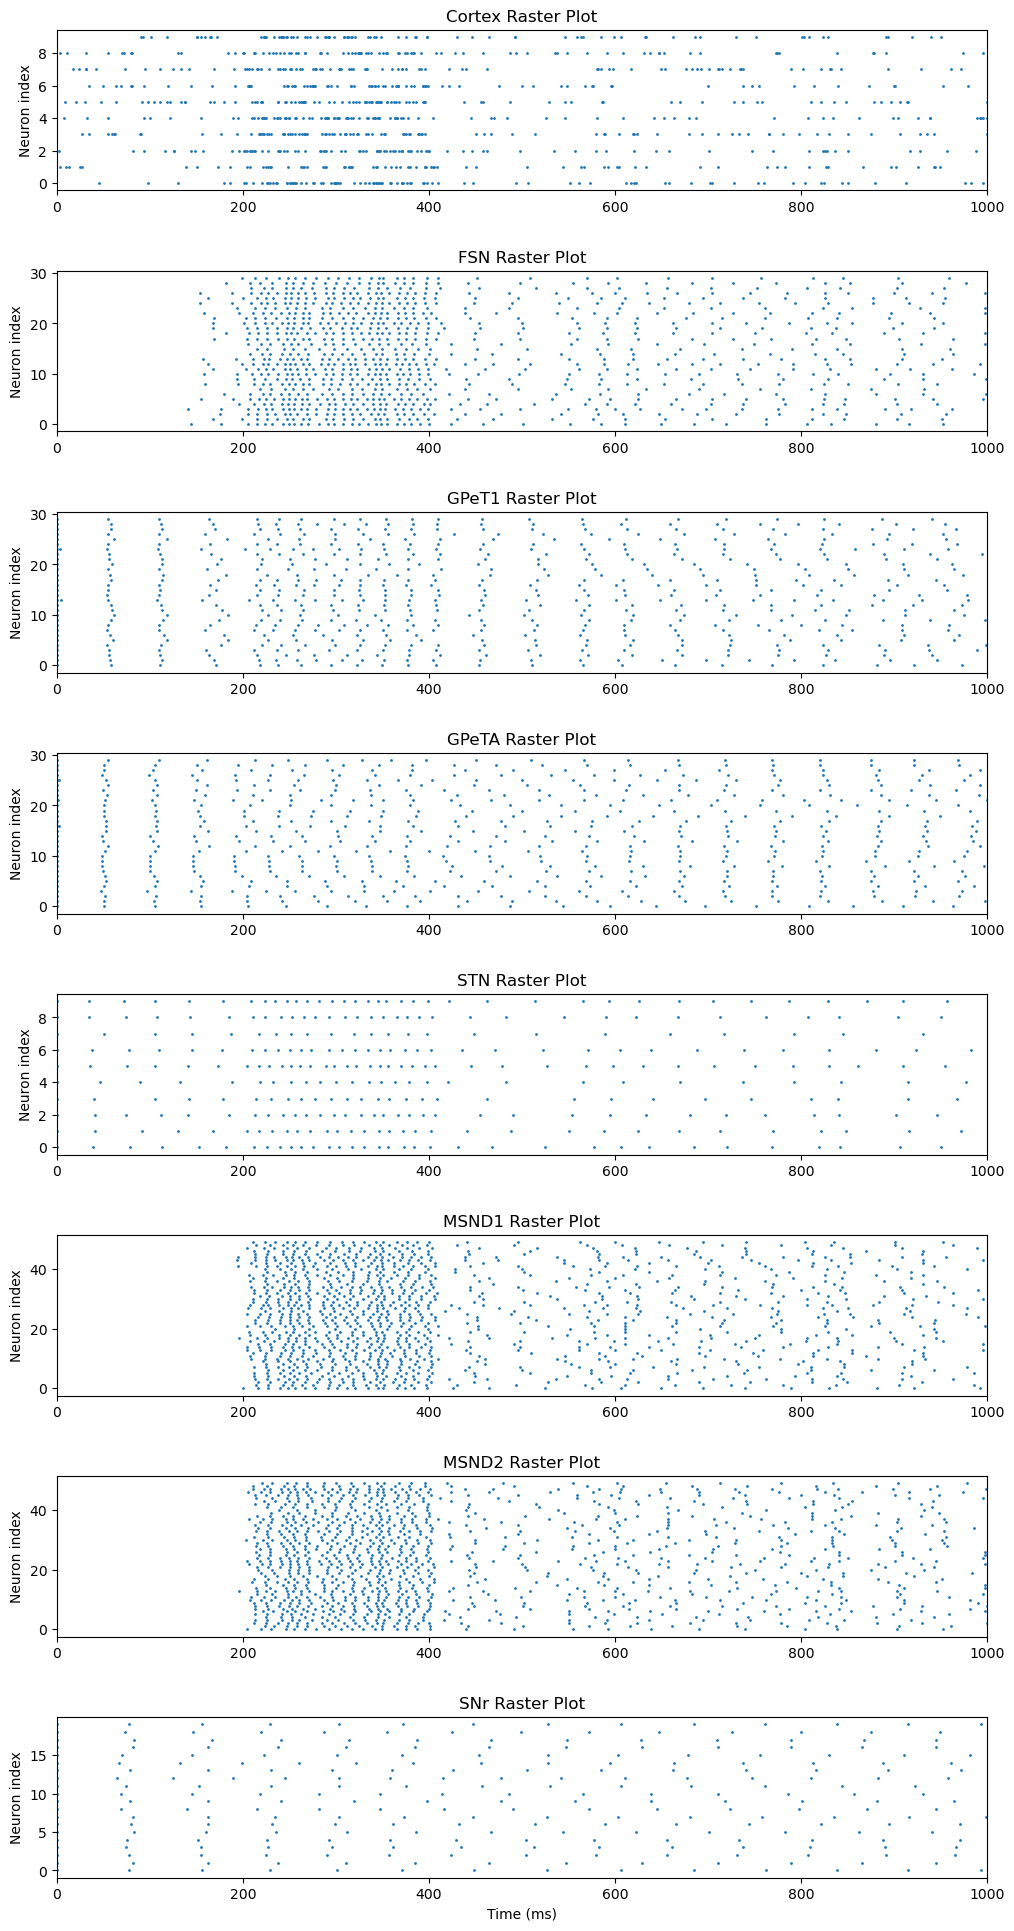

In [5]:
### activation & normal 
fsn_params_file = './params_ref/FSN_1_nor.json'
gpet1_params_file = './params_ref/GPe_T1_1.json'
gpeta_params_file = './params_ref/GPe_TA_1_nor.json'
stn_params_file = './params_ref/STN_1.json'
msnd1_params_file = './params_ref/MSN_D1_1_nor.json' 
msnd2_params_file = './params_ref/MSN_D2_1.json' 
snr_params_file = './params_ref/SNr_1_nor.json' 

N_FSN = 30
N_GPe = 30 # 988
N_STN = 10 # 388
N_MSN = 50 # 37971
N_SNr = 20 # 754

neuron_configs = [
    {
        'name': 'Cortex',
        'N': N_STN,  
        'neuron_type': 'poisson',
        'target_rates': {
            'FSN': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 787*Hz + 3*Hz * randn()'
            },
            'MSND1': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 546*Hz + 3*Hz * randn()'
            },
            'MSND2': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 722*Hz + 3*Hz * randn()'
            },
            'STN': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 250*Hz + 3*Hz * randn()'
            }
        }    
    },
    {
        'name': 'FSN',
        'N': N_FSN,
        'params_file': fsn_params_file,
        'model_class': 'FSN'
    },
    {
        'name': 'GPeT1',
        'N': N_GPe,
        'params_file': gpet1_params_file,
        'model_class': 'GPeT1',
    },
    {
        'name': 'GPeTA',
        'N': N_GPe,
        'params_file': gpeta_params_file,
        'model_class': 'GPeTA',
    },
    {
        'name': 'STN',
        'N': N_STN,
        'params_file': stn_params_file,
        'model_class': 'STN',
    },
    {
        'name': 'MSND1',
        'N': N_MSN,
        'params_file': msnd1_params_file,
        'model_class': 'MSND1',
    },
    {
        'name': 'MSND2',
        'N': N_MSN,
        'params_file': msnd2_params_file,
        'model_class': 'MSND2',
    },
    {
        'name': 'SNr',
        'N': N_SNr,
        'params_file': snr_params_file,
        'model_class': 'SNr',
    }
]

results = run_simulation_with_inh_ext_input(
    neuron_configs=neuron_configs,
    synapse_params=synapse_params,
    synapse_class='GPe_STN_inh_ext_dop_nor'
)

plot_order = ['MSND1', 'MSND2', 'FSN', 'GPeT1', 'GPeTA', 'STN', 'SNr']
plot_raster(results)

WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
INFO:root:building '_cython_magic_9d28f8a40187008740767330089f60c4' extension
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -ftree-vectorize -fPIC -fstack-protector-strong -O2 -pipe -fPIE -isystem /opt/anaconda3/envs/brain/include -D_FORTIFY_SOURCE=2 -isystem /opt/anaconda3/envs/brain/include -I/opt/anaconda3/envs/brain/include -I/opt/anaconda3/envs/brain/lib/python3.9/site-p

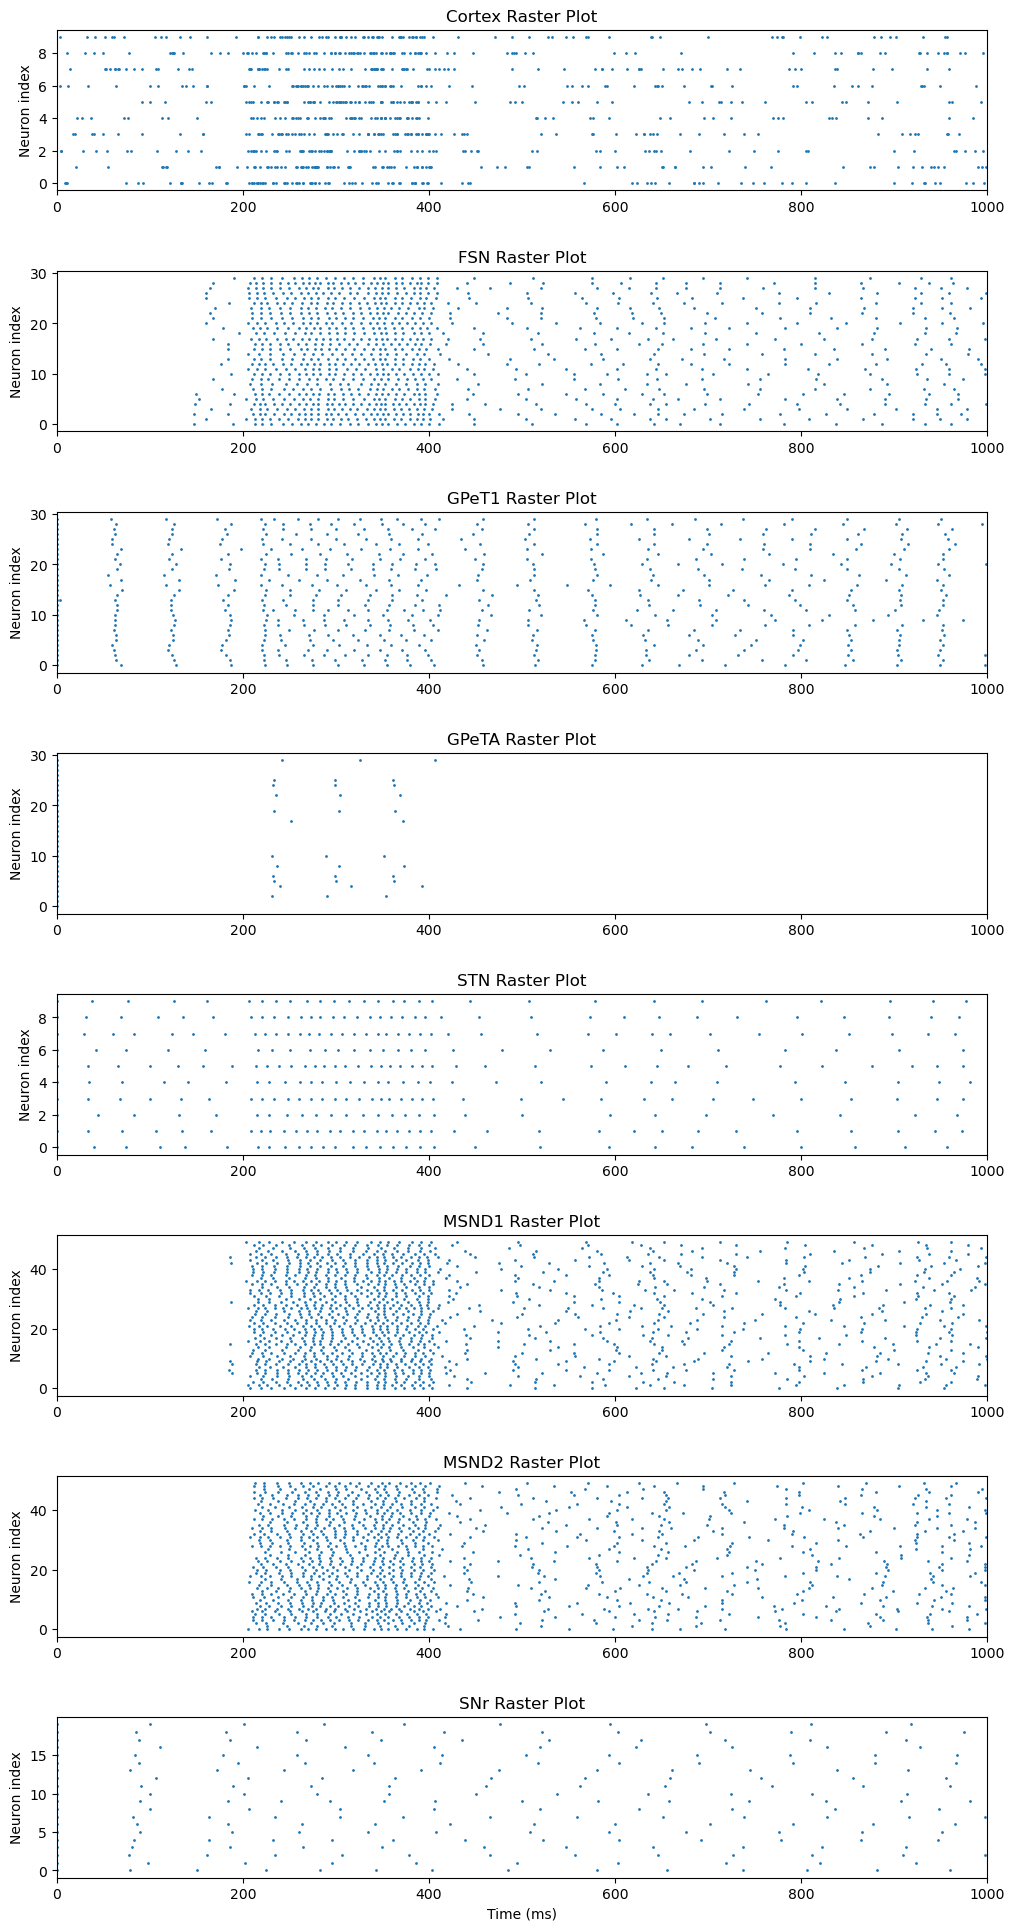

In [6]:
### activation & dop 
fsn_params_file = './params_ref/FSN_1_dop.json'
gpet1_params_file = './params_ref/GPe_T1_1.json'
gpeta_params_file = './params_ref/GPe_TA_1_dop.json'
stn_params_file = './params_ref/STN_1.json'
msnd1_params_file = './params_ref/MSN_D1_1_dop.json' 
msnd2_params_file = './params_ref/MSN_D2_1.json' 
snr_params_file = './params_ref/SNr_1_dop.json' 

neuron_configs = [
    {
        'name': 'Cortex',
        'N': N_STN,  
        'neuron_type': 'poisson',
        'target_rates': {
            'FSN': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 787*Hz + 3*Hz * randn()'
            },
            'MSND1': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 546*Hz + 3*Hz * randn()'
            },
            'MSND2': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 722*Hz + 3*Hz * randn()'
            },
            'STN': {
                'equation': '30*Hz + (t >= 200*ms) * (t < 400*ms) * 250*Hz + 3*Hz * randn()'
            }
        }    
    },
    {
        'name': 'FSN',
        'N': N_FSN,
        'params_file': fsn_params_file,
        'model_class': 'FSN'
    },
    {
        'name': 'GPeT1',
        'N': N_GPe,
        'params_file': gpet1_params_file,
        'model_class': 'GPeT1',
    },
    {
        'name': 'GPeTA',
        'N': N_GPe,
        'params_file': gpeta_params_file,
        'model_class': 'GPeTA',
    },
    {
        'name': 'STN',
        'N': N_STN,
        'params_file': stn_params_file,
        'model_class': 'STN',
    },
    {
        'name': 'MSND1',
        'N': N_MSN,
        'params_file': msnd1_params_file,
        'model_class': 'MSND1',
    },
    {
        'name': 'MSND2',
        'N': N_MSN,
        'params_file': msnd2_params_file,
        'model_class': 'MSND2',
    },
    {
        'name': 'SNr',
        'N': N_SNr,
        'params_file': snr_params_file,
        'model_class': 'SNr',
    }
]

results = run_simulation_with_inh_ext_input(
    neuron_configs=neuron_configs,
    synapse_params=synapse_params,
    synapse_class='GPe_STN_inh_ext_dop_nor'
)

plot_order = ['MSND1', 'MSND2', 'FSN', 'GPeT1', 'GPeTA', 'STN', 'SNr']
plot_raster(results)